In [8]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import sys
from iminuit import Minuit
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sklearn.ensemble import AdaBoostClassifier

In [3]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [10]:
COLOUR = ['#1E90FF', # 0 # Dodgerblue
          '#FFBF00', # 1 # Amber
          '#FF6347', # 2 # Tomato
          '#00A86B', # 3 # Jade
          '#8A2BE2', # 4 # Blueviolet
          '#FF6FFF', # 5 # Ultra Pink
          '#00CCFF', # 6 # Vivid Sky Blue
          '#FFD800', # 7 # School Bus Yellow
          '#FF004F', # 8 # Folly
          '#0063A6', # 9 # Lapis Lazuli
        ]
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
   
    LINE = ['-', '-.', '--', '-.', ':','--','-.','-', ':', '--']
    MARKER = ['.','*', '^', 's', '.', 'p', 'o', 's', '.', 'd']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF)+
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(10)


In [37]:
def getData(fileName):
    dataPath = 'data/'
    data = pd.read_csv(dataPath+fileName, sep=' ', header=None)
    data.columns = ['X', 'Y', 'Z']
    return data

train_signal = getData('training_signal.data')
train_background = getData('training_bg.data')
test_signal = getData('testing_signal.data')
test_background = getData('testing_bg.data')

print(train_signal.head())

print(train_signal['X'].head())

          X         Y          Z
0  2.475303  2.608148  12.929561
1  1.061436  3.681113  14.677241
2  1.265686  3.237551  12.083696
3  2.790318  3.379381  19.206095
4  0.091745  2.642437   6.990892
0    2.475303
1    1.061436
2    1.265686
3    2.790318
4    0.091745
Name: X, dtype: float64


In [38]:
def getTaggedData():
    train_signal['tag'] = 1
    train_background['tag'] = 0
    
    test_signal['tag'] = 1
    test_background['tag'] = 0

    train = pd.concat([train_signal, train_background])
    test = pd.concat([test_signal, test_background])
    return train, test

train, test = getTaggedData()

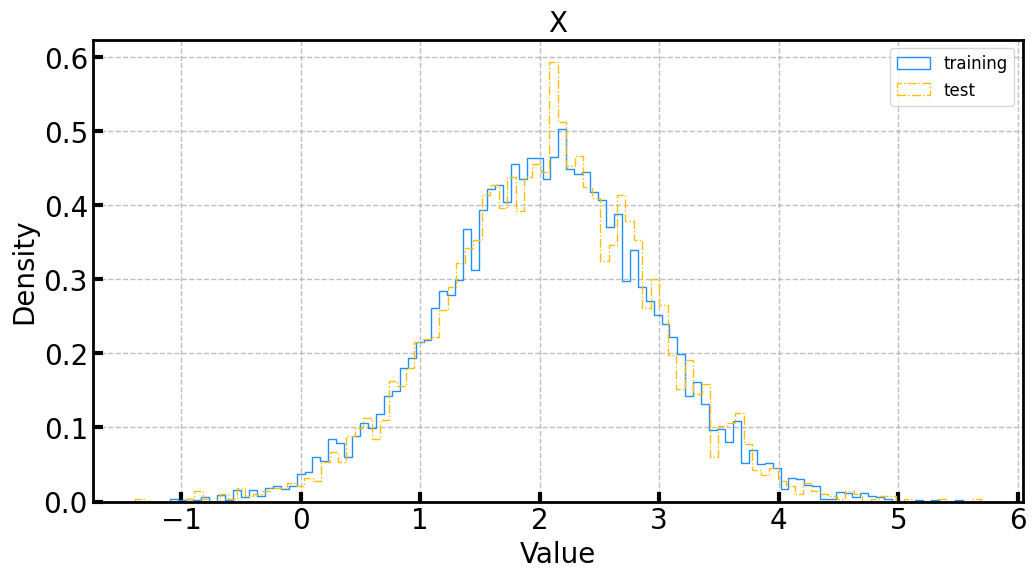

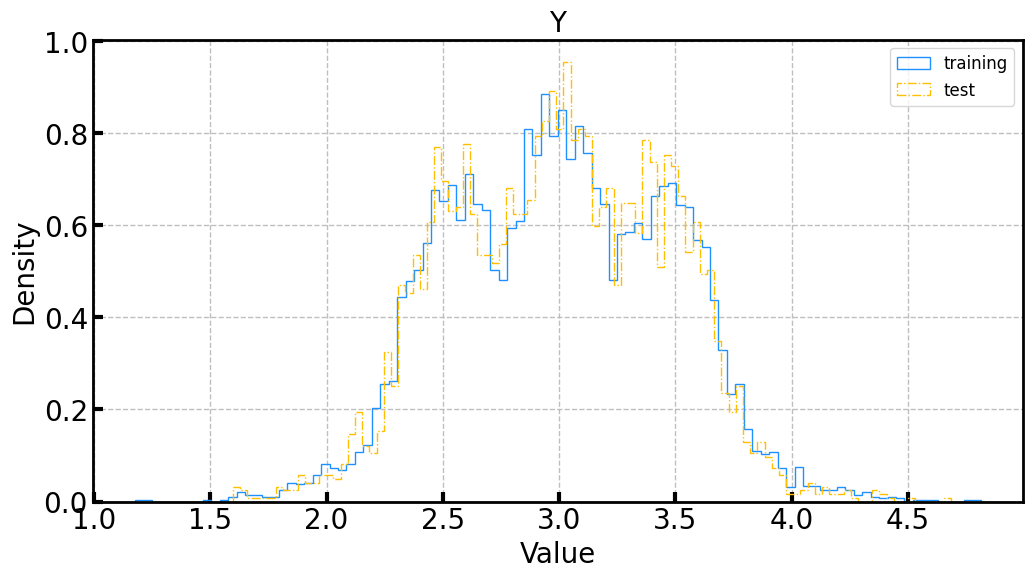

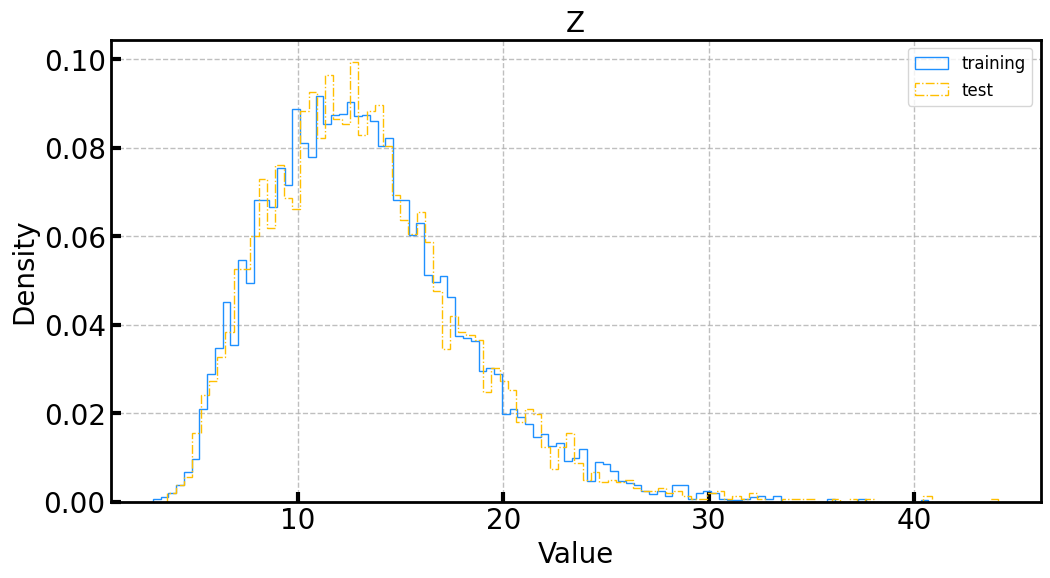

In [42]:
def plotHisto():
    train, test = getTaggedData()
    fig_x, ax_x = plt.subplots(figsize=(12, 6))
    ax_x.hist(train['X'], bins=100, histtype='step', label='training', density=True)
    ax_x.hist(test['X'], bins=100, histtype='step', label='test', density=True)
    ax_x.set_xlabel('Value')
    ax_x.set_ylabel('Density')
    ax_x.set_title('X')
    ax_x.legend()

    fig_y, ax_y = plt.subplots(figsize=(12, 6))
    ax_y.hist(train['Y'], bins=100, histtype='step', label='training', density=True)
    ax_y.hist(test['Y'], bins=100, histtype='step', label='test', density=True)
    ax_y.set_xlabel('Value')
    ax_y.set_ylabel('Density')
    ax_y.set_title('Y')
    ax_y.legend()

    fig_z, ax_z = plt.subplots(figsize=(12, 6))
    ax_z.hist(train['Z'], bins=100, histtype='step', label='training', density=True)
    ax_z.hist(test['Z'], bins=100, histtype='step', label='test', density=True)
    ax_z.set_xlabel('Value')
    ax_z.set_ylabel('Density')
    ax_z.set_title('Z')
    ax_z.legend()

plotHisto()


size of X_train: (8000, 3)
size of y_train: (8000,)
size of X_test: (4000, 3)
size of y_test: (4000,)
size of y_pred: (4000,)


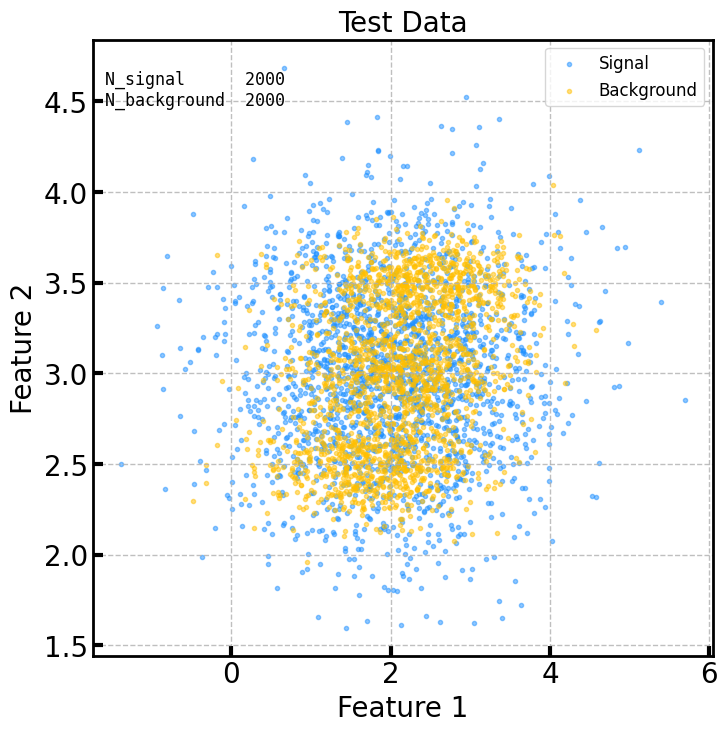

In [29]:
def classify(train, test):
    X_train = train.drop('tag', axis=1)
    y_train = train['tag']
    X_test = test.drop('tag', axis=1)
    y_test = test['tag']
    clf = AdaBoostClassifier(n_estimators=100, random_state=75)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    predict_proba = clf.predict_proba(X_test)
    sig_proba = predict_proba[:,1]
    print(f'size of X_train: {X_train.shape}')
    print(f'size of y_train: {y_train.shape}')
    print(f'size of X_test: {X_test.shape}')
    print(f'size of y_test: {y_test.shape}')
    print(f'size of y_pred: {y_pred.shape}')

    fig, ax = plt.subplots(figsize=(8, 8))
    signal = X_test[y_test==1]
    background = X_test[y_test==0]
    ax.scatter(signal.iloc[:,0], signal.iloc[:,1], label='Signal', alpha=0.5)
    ax.scatter(background.iloc[:,0], background.iloc[:,1], label='Background', alpha=0.5)
    ax.set_title('Test Data')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    d = {'N_signal': len(signal), 'N_background': len(background)}
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.02, 0.95, text, ax, fontsize=12)





classify(train, test)